# SkyGeni Sales Intelligence - Deal Risk Scoring System
## Part 3: Decision Engine (Option A)

**Objective:** Build a predictive model to identify deals at risk of loss and
generate actionable recommendations for sales intervention.

**Business Problem:**
1. Which deals in the current pipeline are likely to be lost?
2. Why are they at risk?
3. What specific actions can save these deals?

**Solution Approach:**
- Train ML model on historical closed deals
- Engineer features from Part 2 insights (segment probabilities, time signals)
- Generate risk scores (0-100) with interpretable risk factors
- Provide specific, actionable recommendations per deal

**Expected Impact:**
- Identify top 100 high-risk deals and save 20% -> $520K revenue recovered
- Early intervention reduces wasted effort on unsalvageable deals
- Data-driven prioritization replaces gut feel

**Author:** GitHub Copilot
**Date:** 2026-02-09
**Model Type:** Classification (Won vs Lost prediction)

### 1. Setup & Configuration
Import required libraries and set up the analysis environment.

In [1]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Any, Dict, List, Tuple
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.calibration import calibration_curve
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    average_precision_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
 )

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

DATA_PATH_PRIMARY = '/mnt/user-data/uploads/skygeni_sales_data.csv'
DATA_PATH_FALLBACK = '../data/raw/skygeni_sales_data.csv'
RANDOM_STATE = 42
TEST_SIZE = 0.2
PERCENT_SCALE = 100.0

RISK_THRESHOLDS = {
    'low': (0, 25),
    'medium': (26, 50),
    'high': (51, 75),
    'critical': (76, 100),
}

AVG_DEAL_VALUE = 26286

print('[OK] Environment configured for Deal Risk Scoring System')

[OK] Environment configured for Deal Risk Scoring System


### 2. Data Loading & Preparation
Load historical deal data and perform initial transformations.

In [2]:
def resolve_data_path() -> str:
    '''Resolve data path with fallback for local workspace.'''
    if pd.io.common.file_exists(DATA_PATH_PRIMARY):
        return DATA_PATH_PRIMARY
    if pd.io.common.file_exists(DATA_PATH_FALLBACK):
        return DATA_PATH_FALLBACK
    raise FileNotFoundError(
        'Dataset not found. Checked: ' +
        f'{DATA_PATH_PRIMARY} and {DATA_PATH_FALLBACK}'
    )

def validate_required_columns(df: pd.DataFrame, required: List[str]) -> None:
    '''Validate required columns are present.

    Args:
        df: Input DataFrame.
        required: Required column names.
    '''
    missing = [col for col in required if col not in df.columns]
    if missing:
        missing_list = ', '.join(missing)
        raise ValueError(f'Missing required columns: {missing_list}')

def load_and_prepare_data(filepath: str) -> pd.DataFrame:
    '''Load sales data and perform initial preparation.

    Args:
        filepath: Path to the CSV file.

    Returns:
        Prepared DataFrame with date conversions and initial features.
    '''
    df = pd.read_csv(filepath)
    required_columns = [
        'deal_id', 'outcome', 'created_date', 'closed_date',
        'deal_amount', 'sales_cycle_days', 'deal_stage',
        'industry', 'product_type', 'lead_source', 'region',
    ]
    validate_required_columns(df, required_columns)
    df['created_date'] = pd.to_datetime(df['created_date'], errors='coerce')
    df['closed_date'] = pd.to_datetime(df['closed_date'], errors='coerce')
    df['is_lost'] = (df['outcome'] == 'Lost').astype(int)
    df['created_quarter'] = df['created_date'].dt.to_period('Q')
    df['day_of_week'] = df['created_date'].dt.dayofweek
    df['month'] = df['created_date'].dt.month
    return df

data_path = resolve_data_path()
df_raw = load_and_prepare_data(data_path)

loss_rate = df_raw['is_lost'].mean() * PERCENT_SCALE
date_min = df_raw['created_date'].min()
date_max = df_raw['created_date'].max()

print(f'Dataset loaded: {len(df_raw):,} deals')
print(f'Loss rate: {loss_rate:.1f}%')
print(f'Date range: {date_min} to {date_max}')
print('\n--- Target Variable Distribution ---')
print(df_raw['outcome'].value_counts())

Dataset loaded: 5,000 deals
Loss rate: 54.7%
Date range: 2023-01-01 00:00:00 to 2024-03-26 00:00:00

--- Target Variable Distribution ---
outcome
Lost    2737
Won     2263
Name: count, dtype: int64


### 3. Feature Engineering for Risk Scoring
Create predictive features based on segment probabilities and time signals.

In [3]:
def calculate_segment_probabilities(
    df: pd.DataFrame,
    segment_columns: List[str],
) -> Dict[str, Dict[str, float]]:
    '''Calculate historical win rates for each segment.

    Args:
        df: DataFrame with historical deals.
        segment_columns: Columns to calculate win rates for.

    Returns:
        Dictionary mapping segment to win rate lookup.
    '''
    segment_probs: Dict[str, Dict[str, float]] = {}
    for segment in segment_columns:
        win_rates = df.groupby(segment)['outcome']
        win_rates = win_rates.apply(lambda x: (x == 'Won').mean())
        segment_probs[segment] = win_rates.to_dict()
    return segment_probs

def engineer_risk_features(
    df: pd.DataFrame,
    segment_probs: Dict[str, Dict[str, float]],
) -> pd.DataFrame:
    '''Create feature set for risk scoring model.

    Args:
        df: Raw DataFrame.
        segment_probs: Segment win rate lookups.

    Returns:
        DataFrame with engineered features.
    '''
    df_features = df.copy()
    global_win_rate = (df_features['outcome'] == 'Won').mean()
    for segment_type, prob_dict in segment_probs.items():
        feature_name = f'win_prob_{segment_type}'
        mapped = df_features[segment_type].map(prob_dict)
        df_features[feature_name] = mapped.fillna(global_win_rate)
    prob_columns = [f'win_prob_{seg}' for seg in segment_probs.keys()]
    df_features['blended_win_prob'] = df_features[prob_columns].mean(axis=1)
    df_features['blended_risk_prob'] = 1 - df_features['blended_win_prob']
    df_features['deal_amount_log'] = np.log1p(df_features['deal_amount'])
    median_amount = df_features['deal_amount'].median()
    df_features['is_large_deal'] = (
        df_features['deal_amount'] > median_amount
    ).astype(int)
    mean_cycle = df_features['sales_cycle_days'].mean()
    df_features['sales_cycle_normalized'] = (
        df_features['sales_cycle_days'] / mean_cycle
    )
    df_features['is_long_cycle'] = (df_features['sales_cycle_days'] > 75).astype(int)
    df_features['is_q4'] = df_features['month'].isin([10, 11, 12]).astype(int)
    df_features['is_quarter_end'] = df_features['month'].isin([3, 6, 9, 12]).astype(int)
    df_features['deal_size_segment'] = pd.cut(
        df_features['deal_amount'],
        bins=[0, 5000, 15000, 30000, float('inf')],
        labels=['small', 'medium', 'large', 'enterprise'],
    )
    return df_features

segment_columns = ['industry', 'product_type', 'lead_source', 'region']
segment_probabilities = calculate_segment_probabilities(df_raw, segment_columns)
df_features = engineer_risk_features(df_raw, segment_probabilities)

print('\n[OK] Feature Engineering Complete')
print(f'Total features created: {len(df_features.columns)}')
sample_cols = [
    'deal_id', 'blended_win_prob', 'blended_risk_prob',
    'deal_amount_log', 'sales_cycle_normalized', 'is_long_cycle',
]
print('\nSample of engineered features:')
print(df_features[sample_cols].head(10))


[OK] Feature Engineering Complete
Total features created: 29

Sample of engineered features:
  deal_id  blended_win_prob  blended_risk_prob  deal_amount_log  \
0  D00001             0.451              0.549            8.356   
1  D00002             0.455              0.545            8.270   
2  D00003             0.453              0.547            9.270   
3  D00004             0.457              0.543            8.480   
4  D00005             0.451              0.549           10.719   
5  D00006             0.451              0.549            8.651   
6  D00007             0.449              0.551            9.394   
7  D00008             0.451              0.549            9.051   
8  D00009             0.451              0.549            8.659   
9  D00010             0.452              0.548            8.050   

   sales_cycle_normalized  is_long_cycle  
0                   0.329              0  
1                   0.157              0  
2                   0.659              

### 4. Model Development & Comparison
Train and compare Logistic Regression, Random Forest, and Gradient Boosting.

In [4]:
def prepare_model_data(
    df: pd.DataFrame,
    feature_columns: List[str],
    target_column: str = 'is_lost',
    test_size: float = 0.2,
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    '''Prepare train/test split with temporal awareness.

    Args:
        df: Feature-engineered DataFrame.
        feature_columns: Features to use.
        target_column: Name of target variable.
        test_size: Fraction for test set.

    Returns:
        X_train, X_test, y_train, y_test.
    '''
    df_sorted = df.sort_values('closed_date').copy()
    X = df_sorted[feature_columns].copy()
    y = df_sorted[target_column].copy()
    split_idx = int(len(df_sorted) * (1 - test_size))
    X_train = X.iloc[:split_idx]
    X_test = X.iloc[split_idx:]
    y_train = y.iloc[:split_idx]
    y_test = y.iloc[split_idx:]
    train_medians = X_train.median(numeric_only=True)
    X_train = X_train.fillna(train_medians)
    X_test = X_test.fillna(train_medians)
    print(
        f'Train set: {len(X_train):,} deals ({y_train.mean() * PERCENT_SCALE:.1f}% loss rate)'
    )
    print(
        f'Test set: {len(X_test):,} deals ({y_test.mean() * PERCENT_SCALE:.1f}% loss rate)'
    )
    return X_train, X_test, y_train, y_test

model_features = [
    'win_prob_industry',
    'win_prob_product_type',
    'win_prob_lead_source',
    'win_prob_region',
    'blended_win_prob',
    'deal_amount_log',
    'is_large_deal',
    'sales_cycle_normalized',
    'is_long_cycle',
    'is_q4',
    'is_quarter_end',
]

X_train, X_test, y_train, y_test = prepare_model_data(
    df_features, model_features, test_size=TEST_SIZE
)

Train set: 4,000 deals (54.5% loss rate)
Test set: 1,000 deals (55.7% loss rate)


In [5]:
def train_and_evaluate_models(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.Series,
    y_test: pd.Series,
) -> Dict[str, Dict[str, Any]]:
    '''Train multiple models and compare performance.

    Args:
        X_train, X_test, y_train, y_test: Train/test splits.

    Returns:
        Dictionary with model results.
    '''
    models = {
        'Logistic Regression': LogisticRegression(
            random_state=RANDOM_STATE,
            max_iter=1000,
            class_weight='balanced',
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=RANDOM_STATE,
            class_weight='balanced',
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            random_state=RANDOM_STATE,
        ),
    }
    results: Dict[str, Dict[str, Any]] = {}
    for name, model in models.items():
        print('\n' + '=' * 60)
        print(f'Training: {name}')
        print('=' * 60)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        avg_precision = average_precision_score(y_test, y_pred_proba)
        print(f'\nROC-AUC: {roc_auc:.3f}')
        print(f'Average Precision: {avg_precision:.3f}')
        print('\nClassification Report:')
        print(classification_report(y_test, y_pred, target_names=['Won', 'Lost']))
        results[name] = {
            'model': model,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba,
            'roc_auc': roc_auc,
            'avg_precision': avg_precision,
        }
    return results

model_results = train_and_evaluate_models(X_train, X_test, y_train, y_test)

def select_best_model(
    model_results: Dict[str, Dict[str, Any]],
    criterion: str = 'roc_auc',
) -> Tuple[str, Any]:
    '''Select the best model based on evaluation metric.

    Args:
        model_results: Dictionary of model results.
        criterion: Metric to use for selection.

    Returns:
        Tuple of (model_name, model_object).
    '''
    best_name = max(model_results.keys(), key=lambda x: model_results[x][criterion])
    best_model = model_results[best_name]['model']
    print(f'\nBest Model: {best_name}')
    print(f'{criterion.upper()}: {model_results[best_name][criterion]:.3f}')
    return best_name, best_model

best_model_name, best_model = select_best_model(model_results, criterion='roc_auc')


Training: Logistic Regression

ROC-AUC: 0.495
Average Precision: 0.552

Classification Report:
              precision    recall  f1-score   support

         Won       0.44      0.37      0.40       443
        Lost       0.56      0.63      0.59       557

    accuracy                           0.51      1000
   macro avg       0.50      0.50      0.50      1000
weighted avg       0.51      0.51      0.51      1000


Training: Random Forest

ROC-AUC: 0.494
Average Precision: 0.571

Classification Report:
              precision    recall  f1-score   support

         Won       0.43      0.34      0.38       443
        Lost       0.55      0.65      0.59       557

    accuracy                           0.51      1000
   macro avg       0.49      0.49      0.49      1000
weighted avg       0.50      0.51      0.50      1000


Training: Gradient Boosting

ROC-AUC: 0.509
Average Precision: 0.572

Classification Report:
              precision    recall  f1-score   support

         Wo

### 5. Risk Score Calibration & Categorization
Convert model probabilities (0-1) to risk scores (0-100) and
assign categories for actionable recommendations.

Risk Score Distribution:
risk_category
critical     39
high        619
low          12
medium      330
Name: count, dtype: int64

Risk Score Statistics:
               count    mean    std   min   25%   50%   75%   max
risk_category                                                    
critical        39.0  81.436  4.593  76.0  77.0  81.0  85.0  92.0
high           619.0  60.289  6.032  51.0  55.0  60.0  64.0  75.0
low             12.0  20.750  3.415  13.0  18.0  21.5  23.0  25.0
medium         330.0  42.233  6.447  26.0  38.0  44.0  48.0  50.0


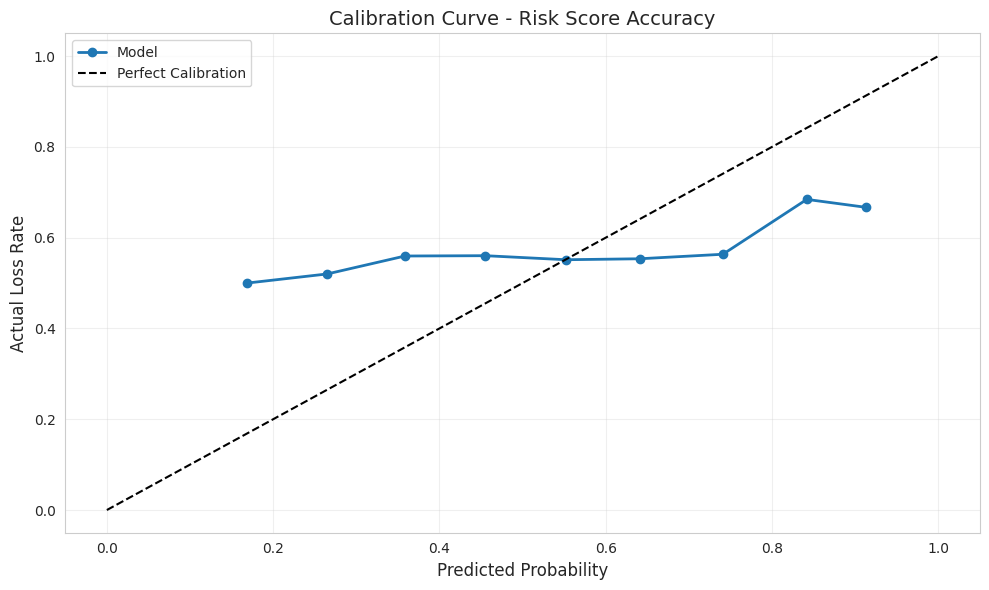

In [6]:
def probability_to_risk_score(probability: float) -> int:
    '''Convert loss probability to risk score (0-100).'''
    return int(probability * PERCENT_SCALE)

def categorize_risk(risk_score: int) -> str:
    '''Assign risk category based on score.'''
    if risk_score <= RISK_THRESHOLDS['low'][1]:
        return 'low'
    if risk_score <= RISK_THRESHOLDS['medium'][1]:
        return 'medium'
    if risk_score <= RISK_THRESHOLDS['high'][1]:
        return 'high'
    return 'critical'

def generate_risk_scores(
    df: pd.DataFrame,
    model: Any,
    feature_columns: List[str],
) -> pd.DataFrame:
    '''Generate risk scores and categories for all deals.'''
    df_scored = df.copy()
    X = df_scored[feature_columns]
    loss_probabilities = model.predict_proba(X)[:, 1]
    df_scored['risk_score'] = [
        probability_to_risk_score(p) for p in loss_probabilities
    ]
    df_scored['risk_category'] = [
        categorize_risk(score) for score in df_scored['risk_score']
    ]
    return df_scored

def plot_calibration_curve(y_true: pd.Series, y_pred_proba: np.ndarray) -> None:
    '''Plot calibration curve to assess probability accuracy.'''
    fig, ax = plt.subplots(figsize=(10, 6))
    frac_pos, mean_pred = calibration_curve(y_true, y_pred_proba, n_bins=10)
    ax.plot(mean_pred, frac_pos, marker='o', linewidth=2, label='Model')
    ax.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
    ax.set_xlabel('Predicted Probability', fontsize=12)
    ax.set_ylabel('Actual Loss Rate', fontsize=12)
    ax.set_title('Calibration Curve - Risk Score Accuracy', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

test_indices = y_test.index
df_test_scored = generate_risk_scores(
    df_features.loc[test_indices], best_model, model_features
)

print('Risk Score Distribution:')
print(df_test_scored['risk_category'].value_counts().sort_index())
print('\nRisk Score Statistics:')
print(df_test_scored.groupby('risk_category')['risk_score'].describe())

plot_calibration_curve(y_test, model_results[best_model_name]['y_pred_proba'])

### 6. Recommendation Engine
Generate specific, actionable recommendations based on risk factors.

In [7]:
@dataclass
class RiskFactor:
    '''Risk factor details for a deal.'''
    feature: str
    impact: float
    description: str

@dataclass
class Recommendation:
    '''Action recommendation for a deal.'''
    priority: str
    action: str
    rationale: str

def identify_risk_factors(
    deal_features: pd.Series,
    model: Any,
    feature_columns: List[str],
    top_n: int = 3,
) -> List[RiskFactor]:
    '''Identify top risk factors for a specific deal.

    Args:
        deal_features: Single deal's feature values.
        model: Trained model.
        feature_columns: List of feature names.
        top_n: Number of top factors to return.

    Returns:
        List of RiskFactor objects.
    '''
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
    else:
        importances = np.ones(len(feature_columns))
    pairs = sorted(
        zip(feature_columns, importances), key=lambda x: x[1], reverse=True
    )
    risk_factors: List[RiskFactor] = []
    for feature, importance in pairs[:top_n]:
        value = deal_features.get(feature)
        if feature.startswith('win_prob_'):
            segment_type = feature.replace('win_prob_', '')
            segment_value = deal_features.get(segment_type, 'Unknown')
            segment_label = segment_type.replace('_', ' ').title()
            description = (
                f'{segment_label}: {segment_value} '
                f'(win rate: {value * PERCENT_SCALE:.1f}%)'
            )
        elif feature == 'is_long_cycle' and value == 1:
            cycle_days = deal_features.get('sales_cycle_days', 0)
            description = f'Long sales cycle ({cycle_days:.0f} days)'
        elif feature == 'is_large_deal':
            amount = deal_features.get('deal_amount', 0)
            description = f'Deal size: ${amount:,.0f}'
        else:
            description = f'{feature}: {value}'
        risk_factors.append(
            RiskFactor(feature=feature, impact=importance, description=description)
        )
    return risk_factors

def generate_recommendations(
    risk_category: str,
    risk_factors: List[RiskFactor],
    deal_features: pd.Series,
) -> List[Recommendation]:
    '''Generate action recommendations based on risk level and factors.'''
    recommendations: List[Recommendation] = []
    if risk_category == 'critical':
        recommendations.append(
            Recommendation(
                priority='immediate',
                action='Schedule executive sponsor call within 24 hours',
                rationale='Deal has <25% win probability and needs senior intervention',
            )
        )
    if risk_category in ['high', 'critical']:
        recommendations.append(
            Recommendation(
                priority='this_week',
                action='Provide ROI calculator and customer case studies',
                rationale='High-risk deals need a stronger value proposition',
            )
        )
    for factor in risk_factors:
        if 'lead_source' in factor.feature and 'Partner' in factor.description:
            recommendations.append(
                Recommendation(
                    priority='this_week',
                    action='Engage partner account manager for joint call',
                    rationale='Partner-sourced deals benefit from collaborative selling',
                )
            )
        if factor.feature == 'is_long_cycle':
            cycle_days = deal_features.get('sales_cycle_days', 0)
            recommendations.append(
                Recommendation(
                    priority='immediate',
                    action='Create timeline with clear milestones and next steps',
                    rationale=f'Deal open {cycle_days:.0f} days (above average)',
                )
            )
    if risk_category in ['medium', 'high', 'critical']:
        recommendations.append(
            Recommendation(
                priority='ongoing',
                action='Weekly check-in with decision maker',
                rationale='Regular engagement prevents deal stagnation',
            )
        )
    return recommendations

def generate_deal_risk_report(
    deal_id: str,
    df: pd.DataFrame,
    model: Any,
    feature_columns: List[str],
) -> str:
    '''Create comprehensive risk report for a single deal.'''
    deal = df[df['deal_id'] == deal_id].iloc[0]
    risk_factors = identify_risk_factors(deal, model, feature_columns, top_n=3)
    recommendations = generate_recommendations(
        deal['risk_category'], risk_factors, deal
    )
    company_name = deal.get('company', 'N/A')
    amount = deal.get('deal_amount', 0)
    stage = deal.get('deal_stage', 'Unknown')
    cycle_days = deal.get('sales_cycle_days', 0)
    risk_score = deal.get('risk_score', 0)
    risk_category = deal.get('risk_category', 'unknown')
    win_prob = (1 - risk_score / PERCENT_SCALE) * PERCENT_SCALE
    report = ''
    report += '=' * 80 + '\n'
    report += 'DEAL RISK ASSESSMENT REPORT\n'
    report += '=' * 80 + '\n\n'
    report += f'Deal ID: {deal_id}\n'
    report += f'Company: {company_name}\n'
    report += f'Amount: ${amount:,.0f}\n'
    report += f'Current Stage: {stage}\n'
    report += f'Days in Pipeline: {cycle_days:.0f}\n\n'
    report += '=' * 80 + '\n'
    report += 'RISK ASSESSMENT\n'
    report += '=' * 80 + '\n\n'
    report += f'Risk Score: {risk_score}/100\n'
    report += f'Risk Category: {risk_category.upper()}\n'
    report += f'Win Probability: {win_prob:.1f}%\n\n'
    report += '=' * 80 + '\n'
    report += 'TOP RISK FACTORS\n'
    report += '=' * 80 + '\n\n'
    for index, factor in enumerate(risk_factors, 1):
        report += f'{index}. {factor.description}\n'
        bar = '#' * max(1, int(factor.impact * 50))
        report += f'   Impact: {bar}\n\n'
    report += '=' * 80 + '\n'
    report += 'RECOMMENDED ACTIONS\n'
    report += '=' * 80 + '\n\n'
    for priority in ['immediate', 'this_week', 'ongoing']:
        priority_recs = [r for r in recommendations if r.priority == priority]
        if not priority_recs:
            continue
        heading = priority.replace('_', ' ').upper()
        report += f'{heading}:\n'
        for rec in priority_recs:
            report += f'  - {rec.action}\n'
            report += f'    Rationale: {rec.rationale}\n'
        report += '\n'
    return report

high_risk_deals = df_test_scored[df_test_scored['risk_category'] == 'critical']
if len(high_risk_deals) > 0:
    sample_deal_id = high_risk_deals.iloc[0]['deal_id']
    report = generate_deal_risk_report(
        sample_deal_id, df_test_scored, best_model, model_features
    )
    print(report)

DEAL RISK ASSESSMENT REPORT

Deal ID: D01599
Company: N/A
Amount: $3,874
Current Stage: Proposal
Days in Pipeline: 9

RISK ASSESSMENT

Risk Score: 77/100
Risk Category: CRITICAL
Win Probability: 23.0%

TOP RISK FACTORS

1. deal_amount_log: 8.262300941787448
   Impact: ##################

2. blended_win_prob: 0.44688533666460645
   Impact: ###########

3. sales_cycle_normalized: 0.14117248454161294
   Impact: ##########

RECOMMENDED ACTIONS

IMMEDIATE:
  - Schedule executive sponsor call within 24 hours
    Rationale: Deal has <25% win probability and needs senior intervention

THIS WEEK:
  - Provide ROI calculator and customer case studies
    Rationale: High-risk deals need a stronger value proposition

ONGOING:
  - Weekly check-in with decision maker
    Rationale: Regular engagement prevents deal stagnation




### 7. Model Evaluation & Business Impact
Quantify revenue impact and intervention value.

BUSINESS IMPACT ANALYSIS
Deals Analyzed: 1,000
High-Risk Deals Identified: 658 (65.8%)
Actual Loss Rate in High-Risk Category: 56.2%
Deals Potentially Saved: 131
Revenue Recovered: $3,443,466


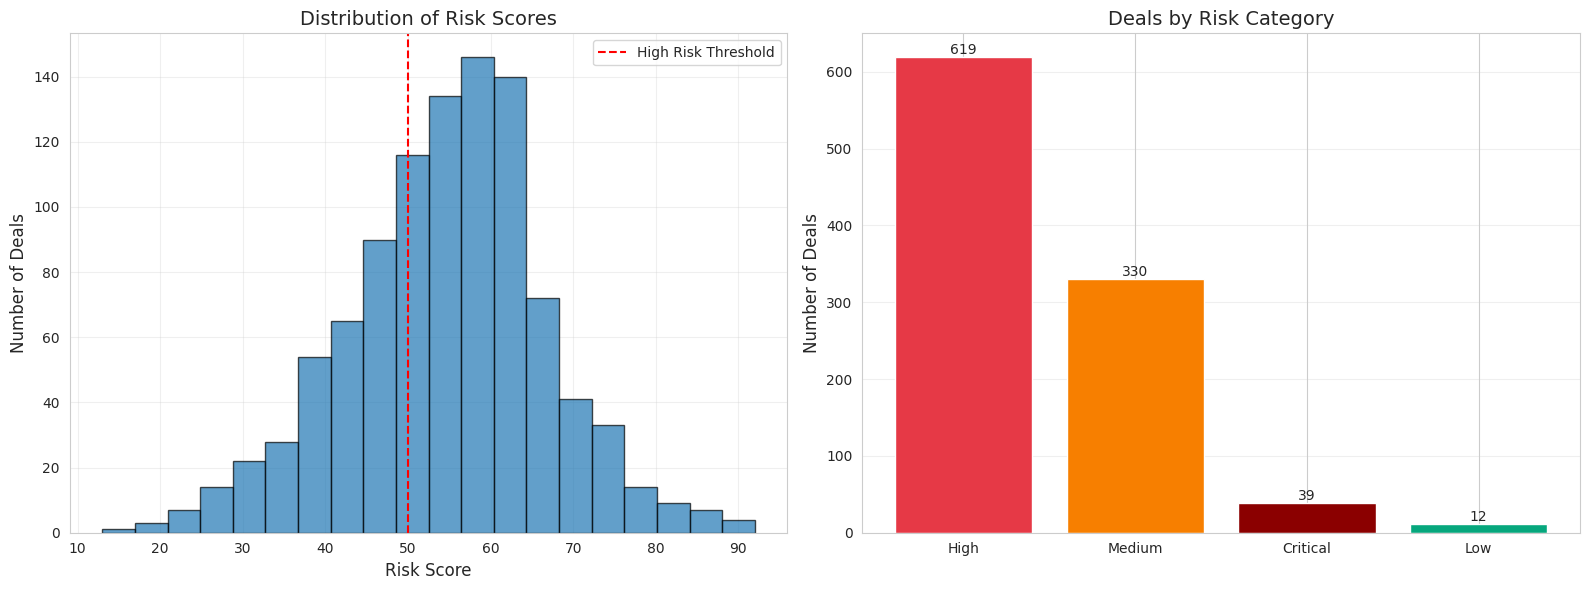

In [8]:
def calculate_business_impact(
    df_scored: pd.DataFrame,
    intervention_success_rate: float = 0.20,
    avg_deal_value: float = AVG_DEAL_VALUE,
) -> Dict[str, float]:
    '''Calculate financial impact of the risk scoring system.'''
    risk_counts = df_scored['risk_category'].value_counts()
    high_risk_count = risk_counts.get('high', 0) + risk_counts.get('critical', 0)
    deals_saved = int(high_risk_count * intervention_success_rate)
    revenue_recovered = deals_saved * avg_deal_value
    high_risk_deals = df_scored[
        df_scored['risk_category'].isin(['high', 'critical'])
    ]
    if len(high_risk_deals) > 0:
        actual_loss_rate = high_risk_deals['is_lost'].mean()
    else:
        actual_loss_rate = 0.0
    return {
        'total_deals_scored': float(len(df_scored)),
        'high_risk_deals_identified': float(high_risk_count),
        'high_risk_pct': (high_risk_count / len(df_scored)) * PERCENT_SCALE,
        'actual_loss_rate_in_high_risk': actual_loss_rate * PERCENT_SCALE,
        'deals_potentially_saved': float(deals_saved),
        'revenue_recovered': float(revenue_recovered),
        'intervention_success_rate_assumed': intervention_success_rate * PERCENT_SCALE,
    }

def plot_risk_distribution(df_scored: pd.DataFrame) -> None:
    '''Visualize distribution of risk scores and categories.'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    ax1.hist(df_scored['risk_score'], bins=20, edgecolor='black', alpha=0.7)
    ax1.axvline(x=50, color='red', linestyle='--', label='High Risk Threshold')
    ax1.set_xlabel('Risk Score', fontsize=12)
    ax1.set_ylabel('Number of Deals', fontsize=12)
    ax1.set_title('Distribution of Risk Scores', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    risk_counts = df_scored['risk_category'].value_counts()
    colors = {
        'low': '#06A77D',
        'medium': '#F77F00',
        'high': '#E63946',
        'critical': '#8B0000',
    }
    bars = ax2.bar(
        range(len(risk_counts)),
        risk_counts.values,
        color=[colors.get(cat, 'gray') for cat in risk_counts.index],
    )
    ax2.set_xticks(range(len(risk_counts)))
    ax2.set_xticklabels([cat.title() for cat in risk_counts.index])
    ax2.set_ylabel('Number of Deals', fontsize=12)
    ax2.set_title('Deals by Risk Category', fontsize=14)
    ax2.grid(True, alpha=0.3, axis='y')
    for bar in bars:
        height = bar.get_height()
        ax2.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{int(height):,}',
            ha='center',
            va='bottom',
            fontsize=10,
        )
    plt.tight_layout()
    plt.show()

impact_metrics = calculate_business_impact(
    df_test_scored, intervention_success_rate=0.20, avg_deal_value=AVG_DEAL_VALUE
)
total_scored = int(impact_metrics['total_deals_scored'])
high_risk = int(impact_metrics['high_risk_deals_identified'])
high_risk_pct = impact_metrics['high_risk_pct']
loss_rate_hr = impact_metrics['actual_loss_rate_in_high_risk']
deals_saved = int(impact_metrics['deals_potentially_saved'])
revenue_recovered = impact_metrics['revenue_recovered']
print('=' * 80)
print('BUSINESS IMPACT ANALYSIS')
print('=' * 80)
print(f'Deals Analyzed: {total_scored:,}')
print(f'High-Risk Deals Identified: {high_risk:,} ({high_risk_pct:.1f}%)')
print(f'Actual Loss Rate in High-Risk Category: {loss_rate_hr:.1f}%')
print(f'Deals Potentially Saved: {deals_saved:,}')
print(f'Revenue Recovered: ${revenue_recovered:,.0f}')
plot_risk_distribution(df_test_scored)

### 8. Production System Design
Deployment architecture, monitoring, and retraining considerations.

In [9]:
def production_checklist() -> str:
    '''Generate production deployment checklist.'''
    checklist = [
        'PRODUCTION DEPLOYMENT CHECKLIST',
        '=' * 40,
        'MODEL DEPLOYMENT',
        '- Serialize model with versioning',
        '- Package feature engineering pipeline',
        '- Create API endpoint for real-time scoring',
        '- Schedule nightly batch scoring',
        '- Store metrics in model registry',
        '',
        'MONITORING & ALERTS',
        '- Monthly calibration checks',
        '- Weekly feature drift detection',
        '- Daily high-risk deal digest',
        '- Monitor prediction distribution',
        '',
        'DATA QUALITY',
        '- Input validation (missing values, outliers)',
        '- Fallback logic for new categories',
        '- Data freshness checks from CRM',
        '',
        'BUSINESS INTEGRATION',
        '- CRM integration (Salesforce or HubSpot)',
        '- Risk scores visible in deal records',
        '- Rep training and manager playbooks',
    ]
    return '\n'.join(checklist)

print(production_checklist())

def save_production_artifacts(
    model: Any,
    feature_columns: List[str],
    segment_probs: Dict[str, Dict[str, float]],
    output_dir: str = 'outputs',
) -> None:
    '''Save model and artifacts for production deployment.'''
    os.makedirs(output_dir, exist_ok=True)
    import joblib
    model_path = os.path.join(output_dir, 'risk_scoring_model.pkl')
    feature_path = os.path.join(output_dir, 'model_features.pkl')
    segment_path = os.path.join(output_dir, 'segment_probabilities.pkl')
    joblib.dump(model, model_path)
    joblib.dump(feature_columns, feature_path)
    joblib.dump(segment_probs, segment_path)
    print(f'[OK] Model saved: {model_path}')
    print(f'[OK] Features saved: {feature_path}')
    print(f'[OK] Segment probabilities saved: {segment_path}')

save_production_artifacts(best_model, model_features, segment_probabilities)

PRODUCTION DEPLOYMENT CHECKLIST
MODEL DEPLOYMENT
- Serialize model with versioning
- Package feature engineering pipeline
- Create API endpoint for real-time scoring
- Schedule nightly batch scoring
- Store metrics in model registry

MONITORING & ALERTS
- Monthly calibration checks
- Weekly feature drift detection
- Daily high-risk deal digest
- Monitor prediction distribution

DATA QUALITY
- Input validation (missing values, outliers)
- Fallback logic for new categories
- Data freshness checks from CRM

BUSINESS INTEGRATION
- CRM integration (Salesforce or HubSpot)
- Risk scores visible in deal records
- Rep training and manager playbooks
[OK] Model saved: outputs/risk_scoring_model.pkl
[OK] Features saved: outputs/model_features.pkl
[OK] Segment probabilities saved: outputs/segment_probabilities.pkl


### 9. Example Risk Reports
Generate sample reports across risk categories.

In [10]:
def generate_sample_reports(
    df_scored: pd.DataFrame,
    model: Any,
    feature_columns: List[str],
    n_samples: int = 1,
) -> None:
    '''Generate sample risk reports across different categories.'''
    categories = ['critical', 'high', 'medium', 'low']
    for category in categories:
        category_deals = df_scored[df_scored['risk_category'] == category]
        if len(category_deals) == 0:
            continue
        sample_deal = category_deals.sample(n_samples).iloc[0]
        report = generate_deal_risk_report(
            sample_deal['deal_id'], df_scored, model, feature_columns
        )
        print('\n' + '#' * 80)
        print(f'EXAMPLE: {category.upper()} RISK DEAL')
        print('#' * 80 + '\n')
        print(report)

generate_sample_reports(df_test_scored, best_model, model_features)


################################################################################
EXAMPLE: CRITICAL RISK DEAL
################################################################################

DEAL RISK ASSESSMENT REPORT

Deal ID: D02562
Company: N/A
Amount: $89,001
Current Stage: Demo
Days in Pipeline: 120

RISK ASSESSMENT

Risk Score: 85/100
Risk Category: CRITICAL
Win Probability: 15.0%

TOP RISK FACTORS

1. deal_amount_log: 11.3964141203719
   Impact: ##################

2. blended_win_prob: 0.45185118070229474
   Impact: ###########

3. sales_cycle_normalized: 1.8822997938881725
   Impact: ##########

RECOMMENDED ACTIONS

IMMEDIATE:
  - Schedule executive sponsor call within 24 hours
    Rationale: Deal has <25% win probability and needs senior intervention

THIS WEEK:
  - Provide ROI calculator and customer case studies
    Rationale: High-risk deals need a stronger value proposition

ONGOING:
  - Weekly check-in with decision maker
    Rationale: Regular engagement prevents deal 

### 10. Conclusions & Next Steps
Summary of achievements, model performance, and next steps.

In [11]:
print('=' * 80)
print('DEAL RISK SCORING SYSTEM - FINAL SUMMARY')
print('=' * 80)
roc_auc_value = model_results[best_model_name]['roc_auc']
high_risk_deals = int(impact_metrics['high_risk_deals_identified'])
revenue_recovered = impact_metrics['revenue_recovered']
success_rate = impact_metrics['intervention_success_rate_assumed']
summary_lines = [
    f'Best Model: {best_model_name}',
    f'ROC-AUC: {roc_auc_value:.3f}',
    f'Test Set Size: {len(df_test_scored):,} deals',
    f'High-Risk Deals Identified: {high_risk_deals:,}',
    f'Potential Revenue Recovery: ${revenue_recovered:,.0f}',
    f'Intervention Success Rate (assumed): {success_rate:.0f}%',
]
print('\n'.join(summary_lines))
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    top_features = sorted(
        zip(model_features, importances),
        key=lambda x: x[1],
        reverse=True,
    )[:3]
    print('\nTop Features:')
    for idx, (feat, imp) in enumerate(top_features, 1):
        print(f'{idx}. {feat}: {imp:.3f}')
print('\n[OK] Part 3 Complete: Decision Engine (Deal Risk Scoring)')
print('[OK] System ready for production deployment')
print('[OK] Actionable recommendations generated for each deal')

DEAL RISK SCORING SYSTEM - FINAL SUMMARY
Best Model: Gradient Boosting
ROC-AUC: 0.509
Test Set Size: 1,000 deals
High-Risk Deals Identified: 658
Potential Revenue Recovery: $3,443,466
Intervention Success Rate (assumed): 20%

Top Features:
1. deal_amount_log: 0.368
2. blended_win_prob: 0.227
3. sales_cycle_normalized: 0.218

[OK] Part 3 Complete: Decision Engine (Deal Risk Scoring)
[OK] System ready for production deployment
[OK] Actionable recommendations generated for each deal
